## **Primer clasificador de imagenes**

In [1]:
# Importamos las bibliotecas necesarias
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# Descargamos el dataset de imagenes
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [3]:
# Información del dataset
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='C:\\Users\\insit\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP

In [4]:
# Separamos los datos en entrenamiento y pruebas
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

# Nombres de las variables
nombres_clases = metadatos.features['label'].names

nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
# Normalizamos los datos
def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32)
    imagenes /= 255         # Aqui normaliza los datos que estaban de 0 a 255 a 0 a 1
    return imagenes, etiquetas

# Aplicamos la función de normalización a los datos de entrenamiento y pruebas
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

# Agregamos a cache los datos
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

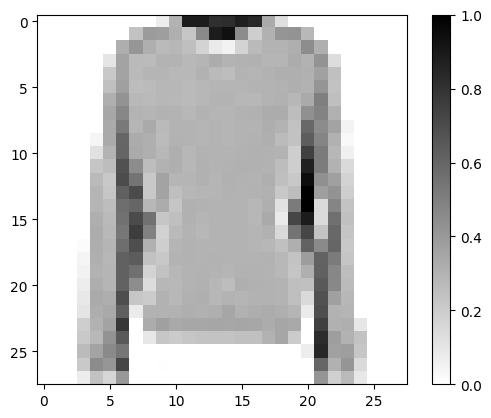

In [6]:
# Mostramos una imagen de ejemplo
for imagen, etiqueta in datos_entrenamiento.take(1):
    break

imagen = imagen.numpy().reshape((28,28))    # Cambiamos el formato de la imagen a 28x28

# Mostramos la imagen
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

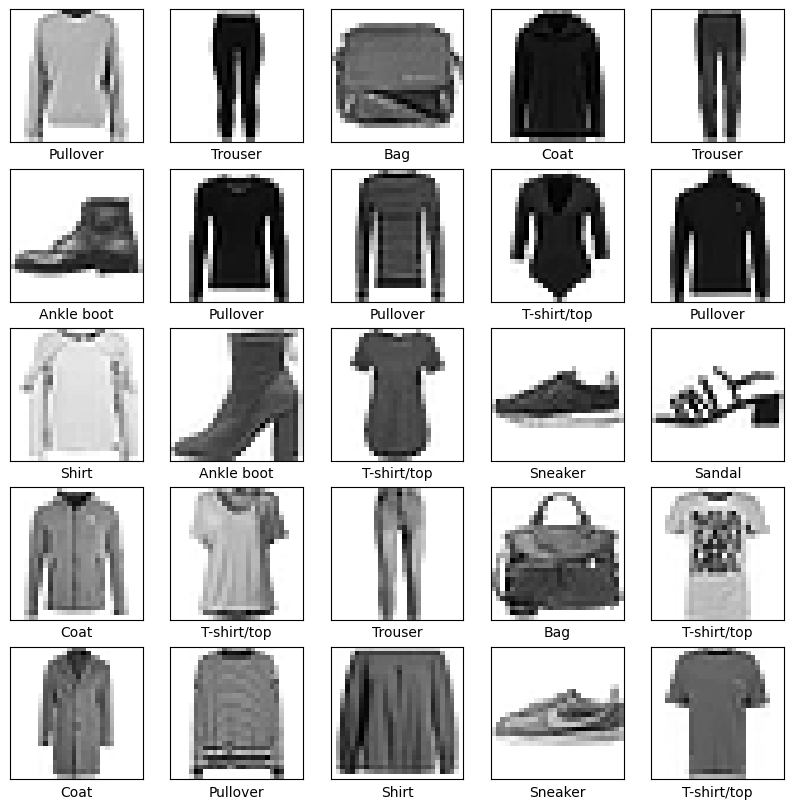

In [7]:
# Mostramos la etiqueta e imagen
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
    imagen = imagen.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagen, cmap=plt.cm.binary)
    plt.xlabel(nombres_clases[etiqueta])
plt.show()


In [9]:
# Creamos el modelo 
modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)), # Aplanar la imagen 
    tf.keras.layers.Dense(50, activation=tf.nn.relu), # Capa oculta 1
    tf.keras.layers.Dense(50, activation=tf.nn.relu), # Capa oculta 2
    tf.keras.layers.Dense(10, activation=tf.nn.softmax) # Capa de salida, 'softmax' para que la suma de las probabilidades sea 1
])

In [10]:
# Compilamos el modelo
modelo.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [11]:
# Obtenemos el numero de ejemplos de entrenamiento y pruebas
num_ej_entrenamiento = metadatos.splits['train'].num_examples
num_ej_pruebas = metadatos.splits['test'].num_examples
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [12]:
# Asignar tamaño de lotes
tamano_lote = 32
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(tamano_lote)
datos_pruebas = datos_pruebas.batch(tamano_lote)

In [13]:
# Entrenamos el modelo
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch=math.ceil(num_ej_entrenamiento/tamano_lote))

Epoch 1/5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7593 - loss: 0.7065
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8574 - loss: 0.3990
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8705 - loss: 0.3519
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8786 - loss: 0.3292
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8830 - loss: 0.3163


{'accuracy': [0.8189499974250793, 0.8609833121299744, 0.8734999895095825, 0.8804333209991455, 0.8871666789054871], 'loss': [0.5195586085319519, 0.3863244652748108, 0.34559065103530884, 0.3249327838420868, 0.3069528639316559]}


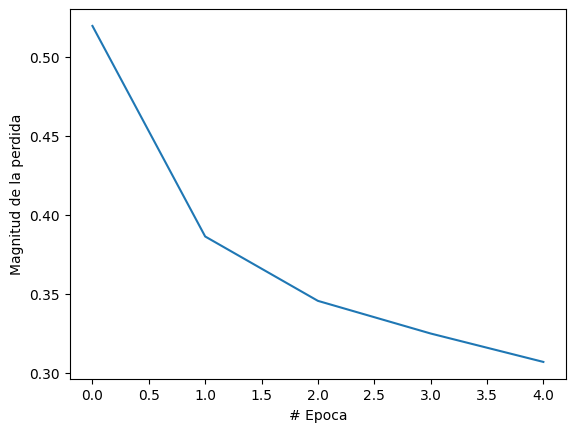

In [14]:
# Imprimimos un resumen del modelo
print(historial.history)

# Graficamos la precisión
plt.xlabel('# Epoca')
plt.ylabel('Magnitud de la perdida')
plt.plot(historial.history['loss'])

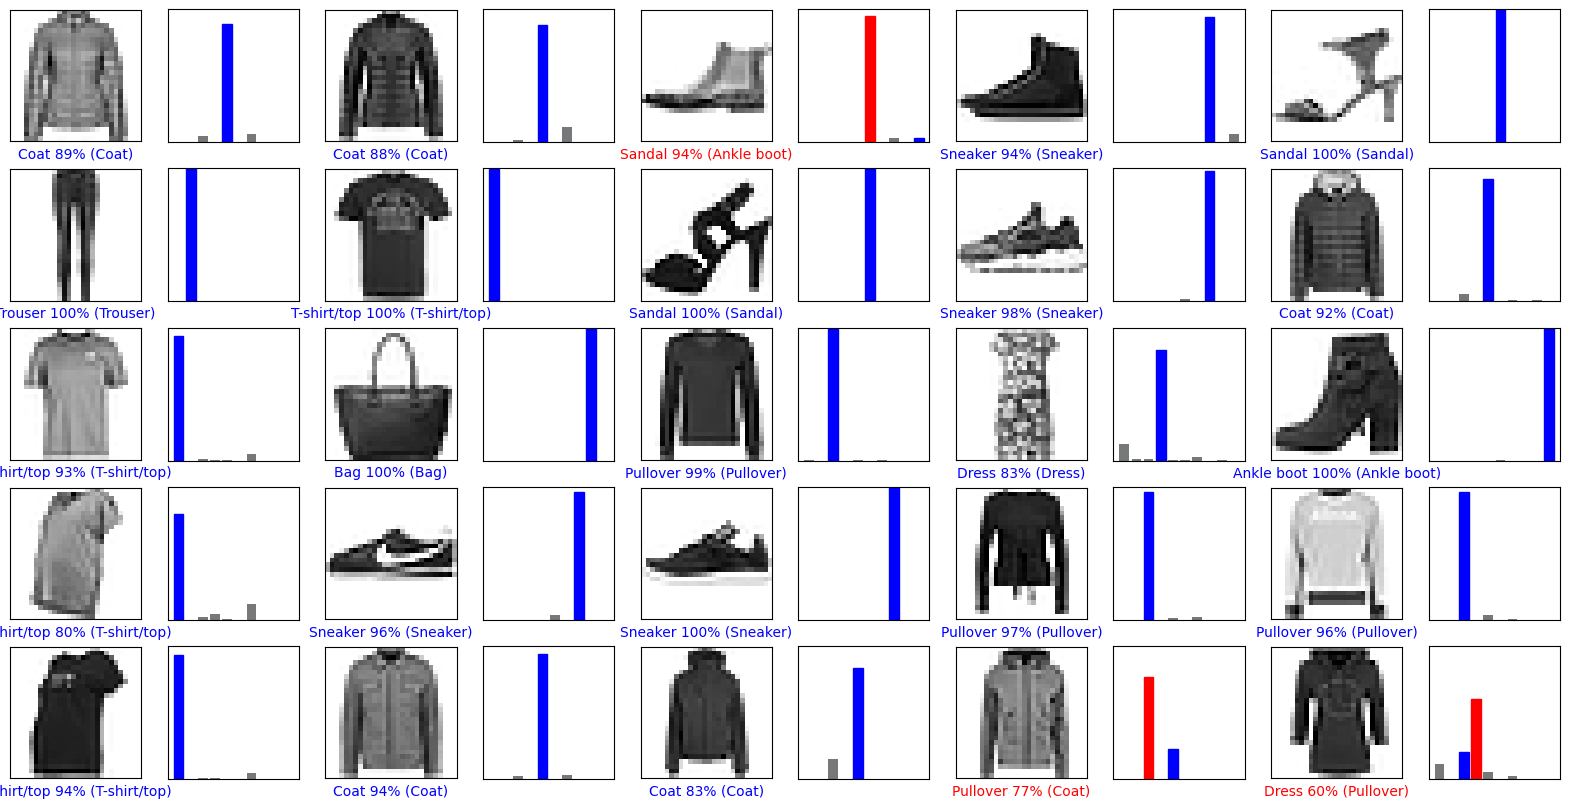

In [15]:
# Imprimir imagenes de prueba
for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
    imagenes_prueba = imagenes_prueba.numpy()
    etiquetas_prueba = etiquetas_prueba.numpy()
    predicciones = modelo(imagenes_prueba)
    n_predicciones = np.argmax(predicciones, axis=-1)
    
# Graficar la primera imagen, predicción y etiqueta de prueba
def graficar_imagen(i, predicciones_array, etiquetas_reales, imagenes):
    predicciones_array, etiqueta_real, img = predicciones_array[i], etiquetas_reales[i], imagenes[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img[...,0], cmap=plt.cm.binary)
    
    etiqueta_predicha = np.argmax(predicciones_array)
    if etiqueta_predicha == etiqueta_real:
        color = 'blue'      # Si la etiqueta predicha es igual a la etiqueta real, el color es azul
    else:
        color = 'red'       # Si la etiqueta predicha es diferente a la etiqueta real, el color es rojo 
    plt.xlabel(f"{nombres_clases[etiqueta_predicha]} {100*np.max(predicciones_array):2.0f}% ({nombres_clases[etiqueta_real]})", color=color)
    
def graficar_valor_arreglo(i, predicciones_array, etiqueta_real):
    predicciones_array, etiqueta_real = predicciones_array[i], etiqueta_real[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    grafica = plt.bar(range(10), predicciones_array, color="#777879")
    plt.ylim([0, 1])
    etiqueta_predicha = np.argmax(predicciones_array)
    
    grafica[etiqueta_predicha].set_color('red')
    grafica[etiqueta_real].set_color('blue')
    
filas = 5
columnas = 5
num_imagenes = filas * columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
    plt.subplot(filas, 2*columnas, 2*i+1)
    graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
    plt.subplot(filas, 2*columnas, 2*i+2)
    graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [16]:
# Predecitr cualquier indice del dataset de pruebas
imagen = imagenes_prueba[10]
imagen = np.array([imagen])
predicciones = modelo.predict(imagen)
print(f'predicción: {nombres_clases[np.argmax(predicciones[0])]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
predicción: T-shirt/top


In [18]:
# Exportar el modelo
modelo.save('modelo_entrenado.h5')
